<a href="https://colab.research.google.com/github/DesaData/DesaData/blob/main/NASDAQ_Stock_Market_Prediction_using_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Importing Libraries

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential #add layer by layer#
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping #stops training when a monitored metric has stopped improving & prevent overfitting#
from tensorflow.random import set_seed
from datetime import datetime
#By setting a random seed, you ensure that the sequence of random numbers can be reproduced.#
#This is crucial for experiments and research, where you need to ensure that results are consistent and reproducible.#
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

2. Run Seed data to ensure randomness and generation of synthetic data

In [29]:
SEED = 123
set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
#initializing weights, generating synthetic data, or setting seeds for reproducibility#


3.Import Our Data

In [30]:
df = pd.read_csv('Nasdaq data.csv')
#ensure its pd.to_datetime()#



4.Change Data to Datetime and Set Date as Index

In [31]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close,Open,High,Low
Date,,,,
2024-12-03,19480.91,19364.34,19486.15,19340.41
2024-12-02,19403.95,19255.42,19436.92,19255.42
2024-11-29,19218.17,19087.47,19245.49,19066.52
2024-11-27,19060.48,19132.99,19133.11,18937.20
2024-11-26,19175.58,19109.08,19184.40,19100.73


5.Arrange Data in Ascending Order

In [32]:
df.sort_index(inplace=True)
df.head()

,Close,Open,High,Low
Date,,,,
2014-12-04,4769.44,4772.00,4785.41,4753.71
2014-12-05,4780.76,4776.58,4788.98,4769.64
2014-12-08,4740.69,4769.76,4793.24,4722.91
2014-12-09,4766.47,4685.20,4768.41,4674.38
2014-12-10,4684.03,4754.42,4766.64,4679.24


6.Visualize the Closing Price

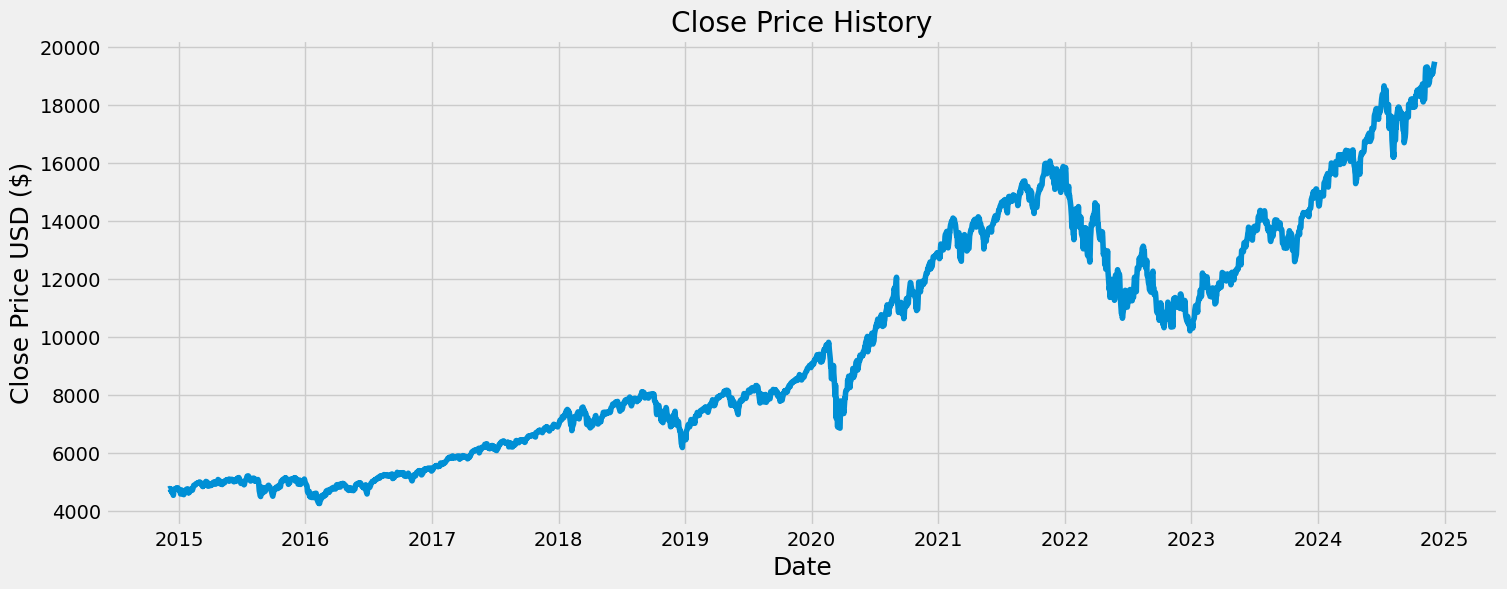

In [33]:
data = np.array(df["Close"]).reshape(-1, 1)

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

7. Normalise the data

In [34]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.03303521],
       [0.03377926],
       [0.03114551],
       ...,
       [0.98273046],
       [0.99494152],
       [1.        ]])

8.Train the Data

In [35]:
# Ratio of sample to use for training vs. testing
TRAIN_SIZE = 0.9 #90% of the data will be used for training and remaming 10% for data validation
#and testing 70-30 large and 80-20 medium data sets#

9.Build the LSTM Model

In [38]:
def get_model(window_size):
    model = Sequential()
    #First Layer
    model.add(LSTM(192, return_sequences=True, input_shape=(window_size, 1)),keras.layers.Dropout(0.3))
    #Second Layer#
    model.add(LSTM(128, return_sequences=True),keras.layers.Dropout(0.3))
    #Third Layer#
    model.add(LSTM(64, return_sequences=False))

    #Output layers
    model.add(Dense(25))
    model.add(Dense(1))#these output layers use activation function linear activation function to output continous value)
    #Compilation of data#
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError']) #Adam combines adagrad hence adjusts learning rate#
    return model

model = get_model(60)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 60, 192)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 60, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,403 (1.39 MB)

 Trainable params: 364,403 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

10.Sliding Window Sequence

In [39]:
def convert_data(prediction_days_in_future, window_size):
    x = []
    y = []

    # Fetch 'WINDOW_SIZE' values as x and the value 'PREDICTION_TARGET' days later as y
    # Slide this window across all days to maximise values
    for i in range(window_size, len(data)-prediction_days_in_future):#create input-output pairs where input consists of a window of past data points& output the value of prediction#
        x.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i+prediction_days_in_future-1, 0])#the i index ensures we are days ahead of the current index i#

    x = np.array(x).reshape(len(x), window_size, 1)
    y = np.array(y)

    n_training_samples = int(len(y) * TRAIN_SIZE)
    X_train = x[:n_training_samples, :]
    y_train = y[:n_training_samples]
    X_test = x[n_training_samples:, :]
    y_test = y[n_training_samples:]

    return X_train, y_train, X_test, y_test, n_training_samples

#Putting togther the Plotting Details#
def plot_results(train, output):
    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(output[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

11. Sliding Window Sequence

In [40]:
def fit_model(days_in_future, window_size):
    print(f"Predicting for {days_in_future} days in future...")
    #fit model uses uses Long Short-Term Memory (LSTM) neural networks for data prediction)

    X_train, y_train, X_test, y_test, n_training_samples = convert_data(days_in_future, window_size)
    #Prepares the dataset for the LSTM model.#
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    #Reverses the scaling on the test set to interpret the predictions correctly.#
    print("Train samples:", len(y_train), "Test samples:", len(y_test))

    # Fit model
    model = get_model(window_size)
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Get the models predicted price values
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)


    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test_original) ** 2)))
    print("RMSE:", rmse)

    # Mean absolute percentage error
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    print("Mean Absolute Percentage Error:", mape)

    # Final prediction error
    error = (np.abs(predictions[-1] - y_test_original[-1]) / y_test_original[-1])[0]
    print("Final Prediction Error:", error)

    # Plot results
    train = df[:n_training_samples+window_size+days_in_future-1]
    output = df[n_training_samples+window_size+days_in_future-1:-1]

    output['Predictions'] = predictions
    plot_results(train, output)

Predicting for 10 days in future...
Train samples: 2210 Test samples: 246
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - RootMeanSquaredError: 0.1689 - loss: 0.0322 - val_RootMeanSquaredError: 0.0639 - val_loss: 0.0041
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - RootMeanSquaredError: 0.0346 - loss: 0.0012 - val_RootMeanSquaredError: 0.0442 - val_loss: 0.0020
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step - RootMeanSquaredError: 0.0321 - loss: 0.0010 - val_RootMeanSquaredError: 0.0469 - val_loss: 0.0022
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - RootMeanSquaredError: 0.0319 - loss: 0.0010 - val_RootMeanSquaredError: 0.0466 - val_loss: 0.0022
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - RootMeanSquaredError: 0.0318 - loss: 0.0010 - val_RootMeanSquaredError: 0.0463 - val_loss: 0.0021


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
RMSE: 704.1450233042096
Mean Absolute Percentage Error: 0.035932023391589116
Final Prediction Error: 0.05143467889269972


<ipython-input-40-70d4251d33b9>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


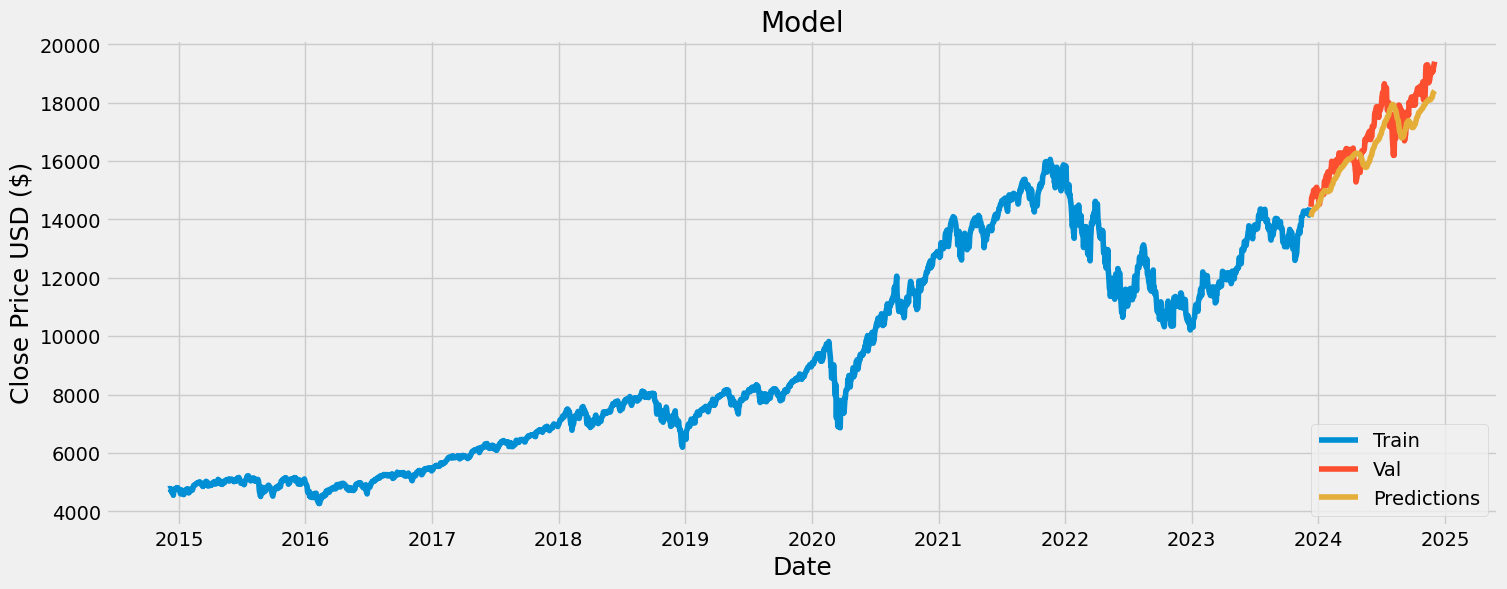

In [41]:
fit_model(days_in_future=10, window_size=60)

12.Experimenting with Different Days

b)Seven days in the future

Predicting for 7 days in future...
Train samples: 2213 Test samples: 246


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - RootMeanSquaredError: 0.1462 - loss: 0.0243 - val_RootMeanSquaredError: 0.0357 - val_loss: 0.0013
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - RootMeanSquaredError: 0.0303 - loss: 9.2293e-04 - val_RootMeanSquaredError: 0.0565 - val_loss: 0.0032
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - RootMeanSquaredError: 0.0276 - loss: 7.6741e-04 - val_RootMeanSquaredError: 0.0675 - val_loss: 0.0046
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - RootMeanSquaredError: 0.0277 - loss: 7.7110e-04 - val_RootMeanSquaredError: 0.0615 - val_loss: 0.0038
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
RMSE: 935.863858888048
Mean Absolute Percentage Error: 0.04915110249634141
Final Prediction Error: 0.06866508252829968


<ipython-input-40-70d4251d33b9>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


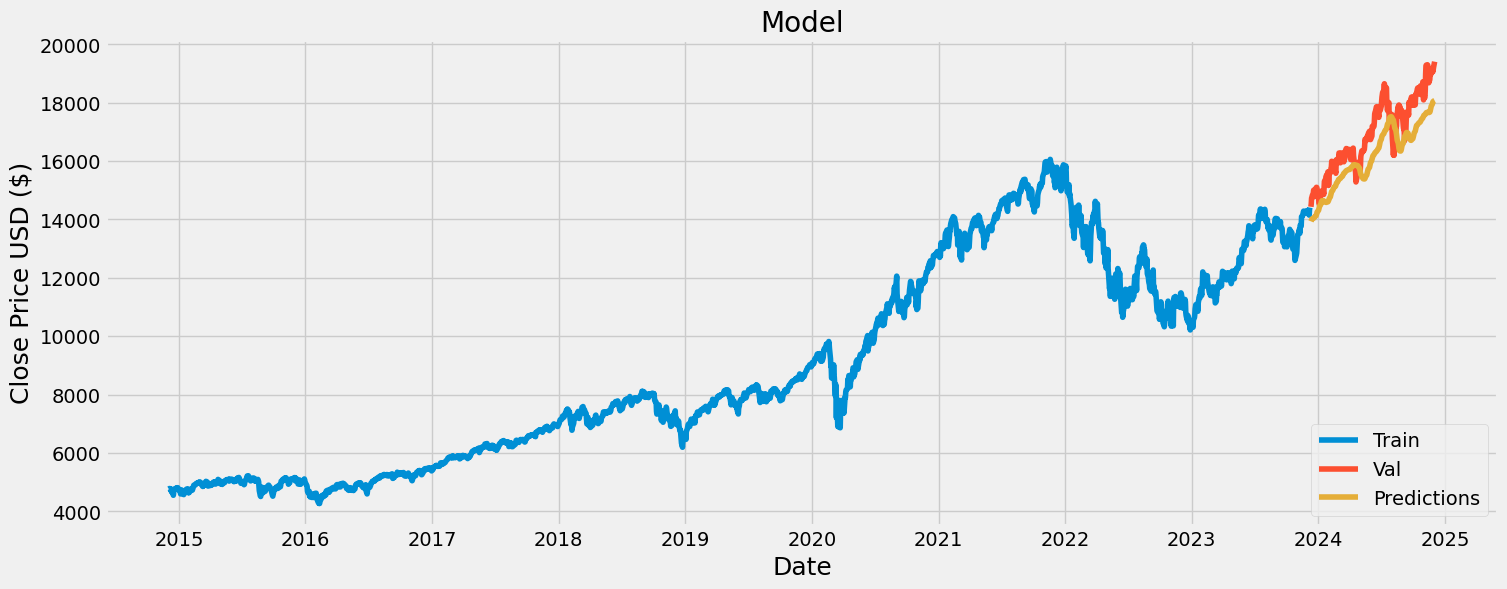

In [42]:
fit_model(days_in_future=7, window_size=60)

b)30 days in the future

Predicting for 30 days in future...
Train samples: 2192 Test samples: 244
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 462ms/step - RootMeanSquaredError: 0.1683 - loss: 0.0314 - val_RootMeanSquaredError: 0.1331 - val_loss: 0.0177
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 431ms/step - RootMeanSquaredError: 0.0510 - loss: 0.0026 - val_RootMeanSquaredError: 0.1004 - val_loss: 0.0101
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - RootMeanSquaredError: 0.0464 - loss: 0.0022 - val_RootMeanSquaredError: 0.1169 - val_loss: 0.0137
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - RootMeanSquaredError: 0.0472 - loss: 0.0022 - val_RootMeanSquaredError: 0.1235 - val_loss: 0.0153
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - RootMeanSquaredError: 0.0471 - loss: 0.0022 - val_RootMeanSquaredError: 0.1188 - val_loss: 0.0141
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
RMSE: 1806.725788412556
Mean Absolute Percentage Error: 0.09776233079194406
Final Prediction Error: 0.13940504864988834


<ipython-input-40-70d4251d33b9>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


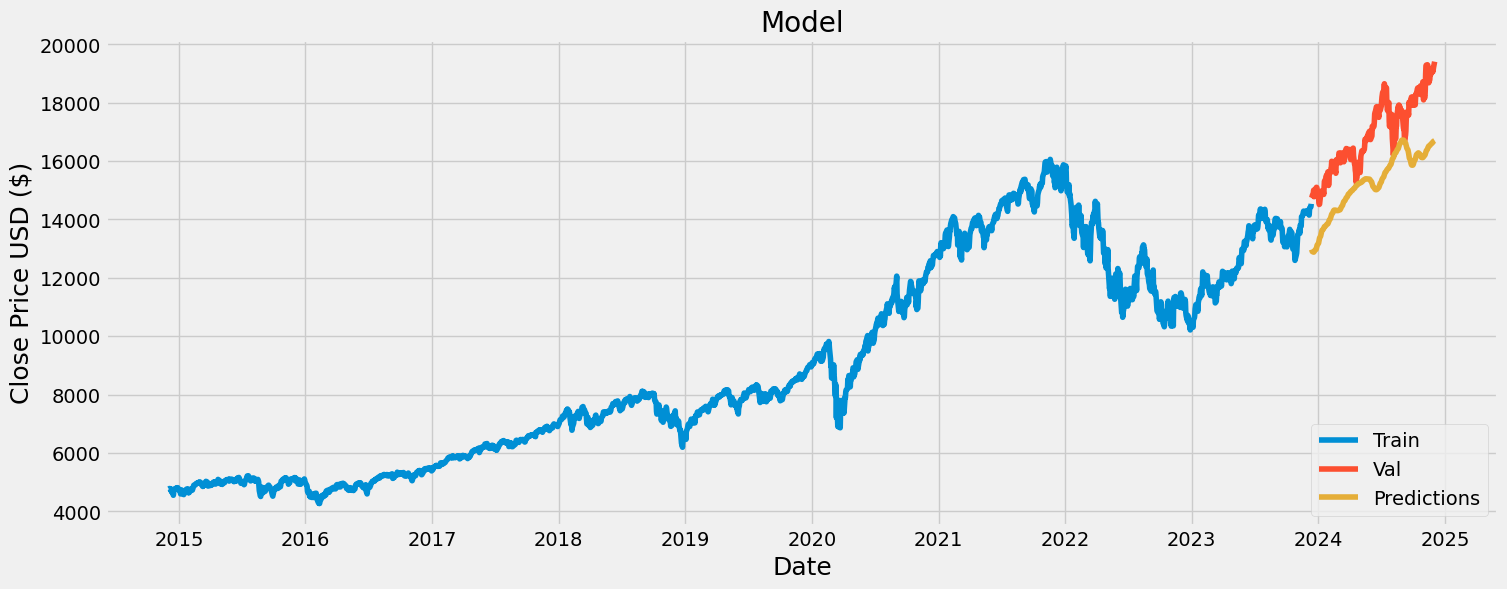

In [43]:
fit_model(days_in_future=30, window_size=60)